In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import time
from sklearn.preprocessing import StandardScaler

In [2]:
import utils

# Read data

In [3]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

In [4]:
data = data[data['detected_bool'] == 1]
metadata = metadata[metadata['ddf_bool'] == 1]

In [5]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

In [9]:
ss = StandardScaler()

# Visual analysis

In [10]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [11]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [12]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject_new = anobject.copy()
    anobject_new.loc[:, 'log_lam'] = np.array(log_lam)
    return anobject_new

In [13]:
def create_approx_object(anobject, n=1000):
    mjd = anobject['mjd'].values
    dfs = []
    for passband in range(6):
        df = pd.DataFrame()
        df['mjd'] = np.linspace(mjd.min(), mjd.max(), n)
        df['object_id'] = 0
        df['passband'] = passband
        df['flux'] = 0
        df['flux_err'] = 0
        df['detected_bool'] = 1
        dfs.append(df)
    new_object = pd.concat(dfs, axis=0)
    new_object = add_log_lam(new_object)
    return new_object

In [14]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [15]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)
    plt.show()

In [16]:
def scaler_transform(anobject):
    X = ss.fit_transform(anobject[['mjd', 'log_lam']].values)
    y = anobject['flux'].values
    return X, y

In [17]:
def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux
    obj['passband'] = passband
    return obj

In [18]:
def flux_not_negativ(anobject):
    anobject_new = anobject.copy()
    anobject_new['flux'] = np.where(anobject_new['flux'] < 0, 0, anobject_new['flux'])
    return anobject_new

34299


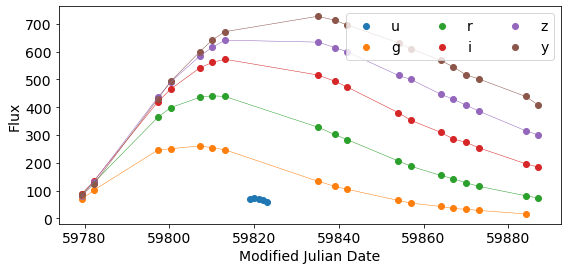

43812


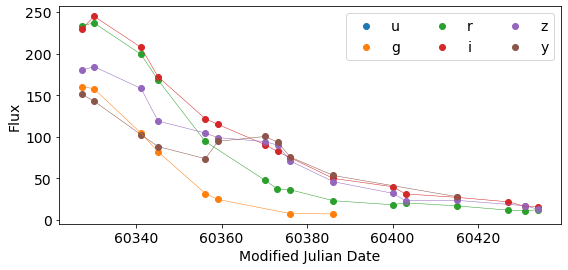

70046


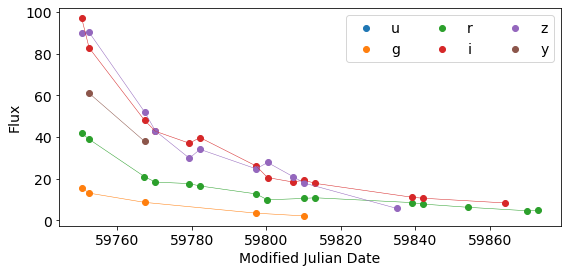

84716


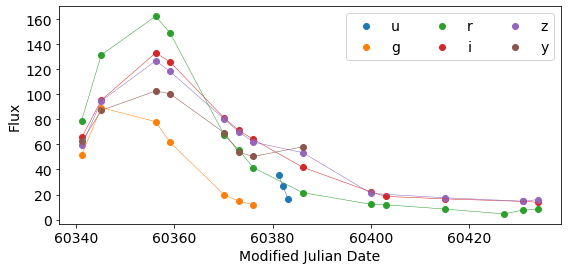

131629


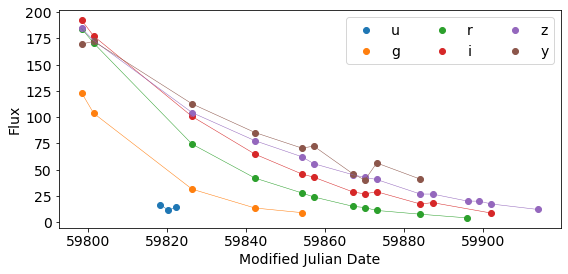

169315


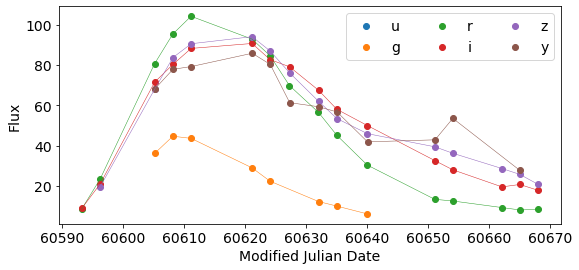

229855


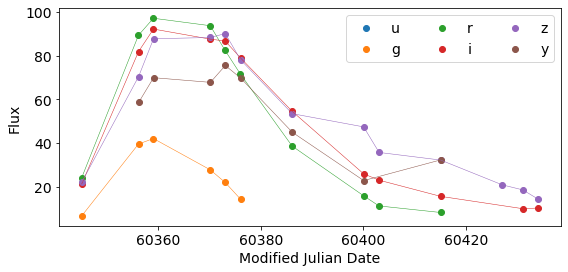

251430


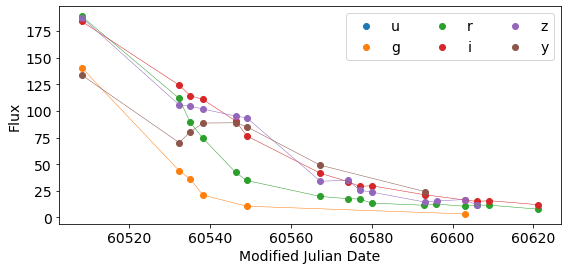

282714


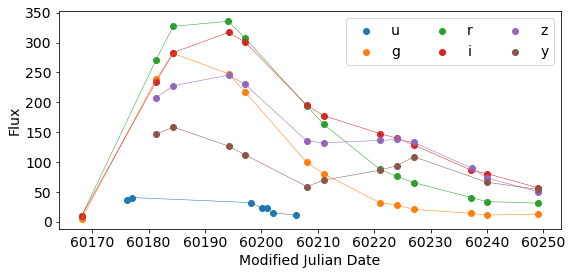

290682


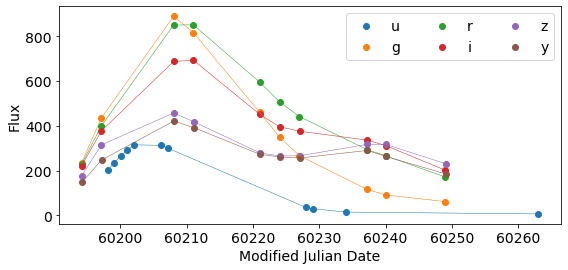

316306


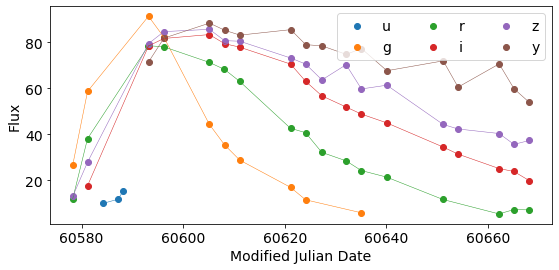

In [19]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()

# One object test Test

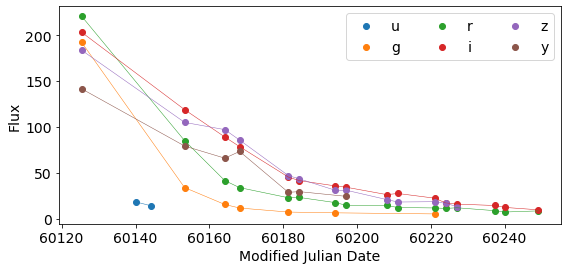

In [20]:
anobject = get_object(data, 745)#43812 34299
anobject = add_log_lam(anobject)

plot_light_curves(anobject)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

In [23]:
kernel = 'LR'

In [24]:
import LR_aug

timer = time.time()
anobject_train = flux_not_negativ(anobject_train)
model = LR_aug.LinearRegressionAugmentation(passband2lam, mod=kernel)
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                 anobject['mjd'].max(), n_obs=1000)

In [25]:
model.score(anobject_train['mjd'].values, anobject_train['flux'].values, 
            anobject_train['flux_err'].values, anobject_train['passband'].values)

0.9019129474128782

In [26]:
anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, 
                                 flux_err_pred, anobject_test['passband'].values)
anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)

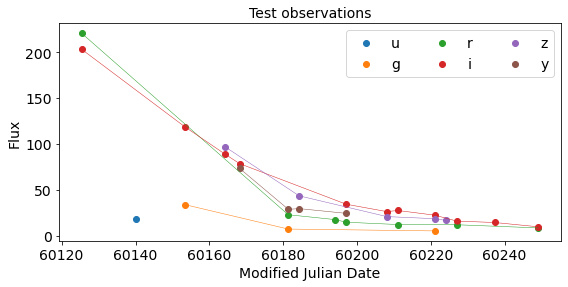

In [27]:
plot_light_curves(anobject_test, "Test observations")

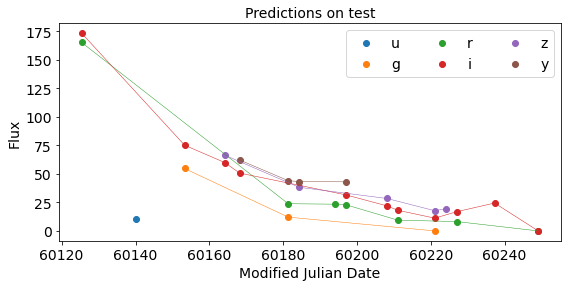

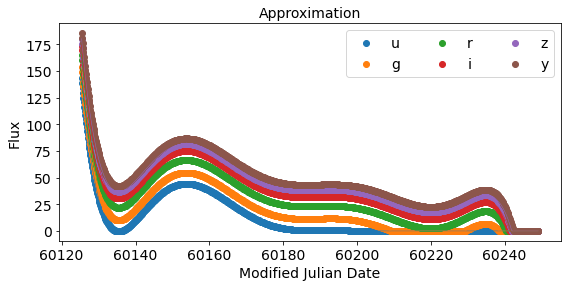

In [28]:
plot_light_curves(anobject_test_pred, "Predictions on test")
plot_light_curves(anobject_aug, "Approximation")

In [29]:
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)
print("Work sec: %f" % (time.time() - timer))

RMSE:  18.488115909325188
MAE:  13.179576890066864
RSE:  0.35318603823735845
RAE:  0.35642562111302434
MAPE:  40.27714065154254
Work sec: 1.893932


# Test on many objects

In [30]:
report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in object_ids: 
    # get an object
    anobject_i = get_object(data, i)
    anobject_i = add_log_lam(anobject_i)

    if not is_good(anobject_i): continue

    print("Object ", i, " with ", len(anobject), " observations")

    # train / test split
    anobject_train, anobject_test = train_test_split(anobject_i, test_size=0.5, random_state=11)

    anobject_train = flux_not_negativ(anobject_train)
    model = LR_aug.LinearRegressionAugmentation(passband2lam, mod=kernel)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)
    
    anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, flux_err_pred, anobject_test['passband'].values)
    
    metric = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
    report.loc[len(report), :] = [i] + metric


Object  745  with  61  observations
Object  1124  with  61  observations
Object  1920  with  61  observations
Object  2922  with  61  observations
Object  4173  with  61  observations
Object  4389  with  61  observations
Object  4819  with  61  observations
Object  6180  with  61  observations
Object  7033  with  61  observations
Object  7164  with  61  observations
Object  10321  with  61  observations
Object  10757  with  61  observations
Object  11359  with  61  observations
Object  11507  with  61  observations
Object  13079  with  61  observations
Object  13138  with  61  observations
Object  13194  with  61  observations
Object  13459  with  61  observations
Object  14279  with  61  observations
Object  14674  with  61  observations
Object  15002  with  61  observations
Object  15674  with  61  observations
Object  15845  with  61  observations
Object  15968  with  61  observations
Object  17370  with  61  observations
Object  18029  with  61  observations
Object  18556  with  61

In [31]:
np.round(report.mean(), 2)

ID      340898.23
RMSE       190.91
MAE         70.05
RSE          5.24
RAE          1.82
MAPE       508.21
dtype: float64

In [32]:
report

,ID,RMSE,MAE,RSE,RAE,MAPE
0,745,18.4881,13.1796,0.353186,0.356426,40.2771
1,1124,16.6343,14.0489,0.447367,0.524874,78.465
2,1920,36.0323,23.7476,0.582535,0.475061,64.8542
3,2922,151.108,48.5754,2.18375,1.38004,223.565
4,4173,12.1187,10.3643,0.244411,0.252559,32.5623
...,...,...,...,...,...,...
511,339169,7.38096,5.28355,0.496017,0.408949,24.1423
512,341653,23.3991,17.3613,0.784638,0.685819,71.485
513,342659,21.8366,13.0844,0.64263,0.469986,47.382
514,8366012,49.8453,39.9002,0.408687,0.362333,33.0781


# Comparison of models

In [33]:
mape_line = pd.DataFrame(columns=["ID", 'model', 'MAPE'])
for i in object_ids: 
    # get an object
    anobject_i = get_object(data, i)
    anobject_i = add_log_lam(anobject_i)

    if not is_good(anobject_i): continue
    key = ["Ridge", "Lasso", "LR"]
    for name in key:
        # train / test split
        anobject_train, anobject_test = train_test_split(anobject_i, test_size=0.5, random_state=11)

        anobject_train = flux_not_negativ(anobject_train)
        model = LR_aug.LinearRegressionAugmentation(passband2lam, mod=name)
        model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
                  anobject_train['flux_err'].values, anobject_train['passband'].values)

        flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

        anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, flux_err_pred, anobject_test['passband'].values)

        [rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
        mape_line.loc[len(mape_line), :] = [i] + [name] + [mape]
    

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038335582385282674, tolerance: 0.003800000000000001
  model = cd_fast.enet_coordinate_descent(


In [34]:
mape_line

,ID,model,MAPE
0,745,Ridge,43.6437
1,745,Lasso,45.0543
2,745,LR,40.2771
3,1124,Ridge,68.9501
4,1124,Lasso,58.0499
...,...,...,...
1543,8366012,Lasso,75.9517
1544,8366012,LR,33.0781
1545,76664408,Ridge,154.925
1546,76664408,Lasso,168.008


In [35]:
mape_line_ridge = mape_line[mape_line['model'] == "Ridge"]
mape_line_lasso = mape_line[mape_line['model'] == "Lasso"]
mape_line_lr = mape_line[mape_line['model'] == "LR"]

mape_line_ridge.index = np.arange(len(mape_line_ridge))
mape_line_lasso.index = np.arange(len(mape_line_ridge))
mape_line_lr.index = np.arange(len(mape_line_ridge))

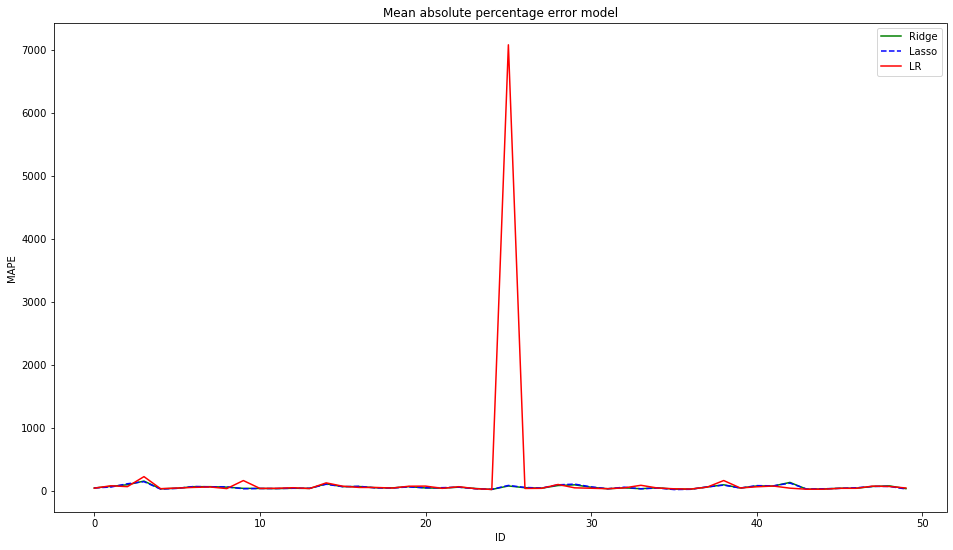

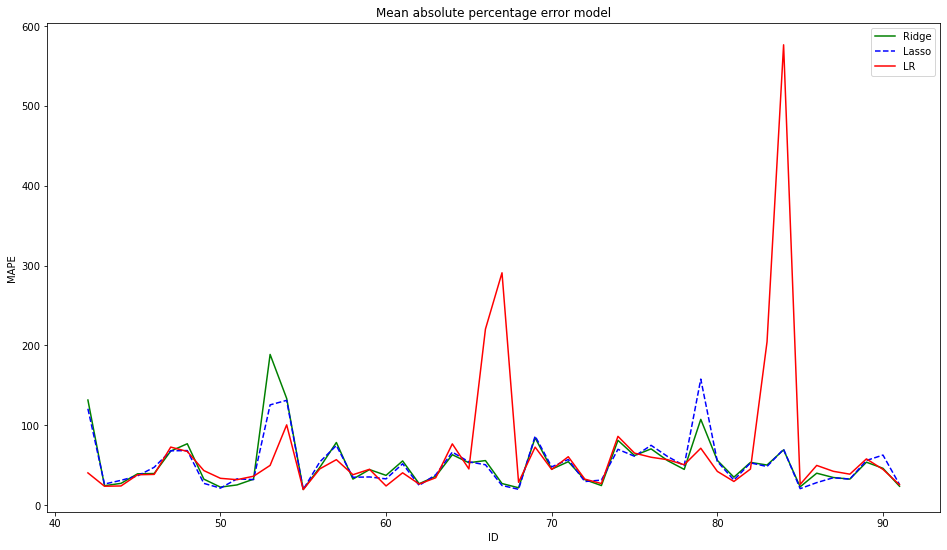

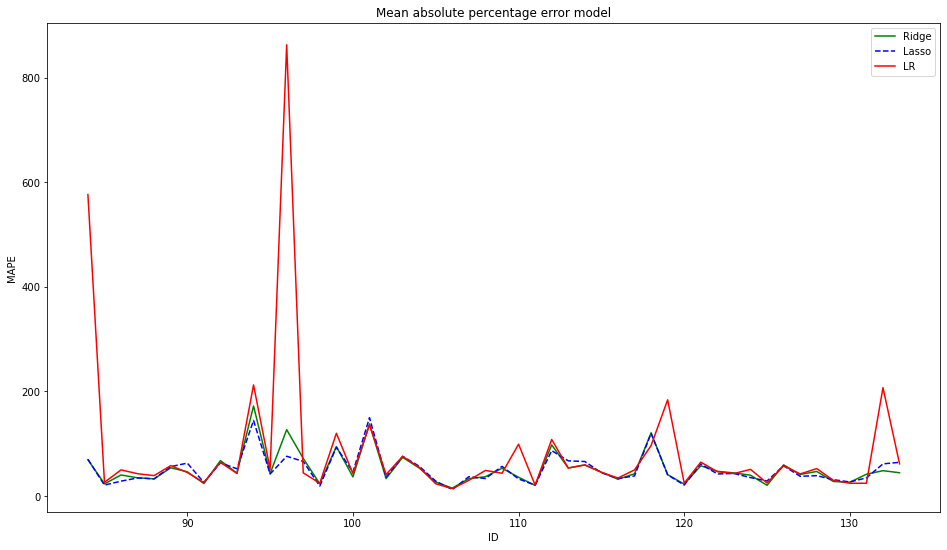

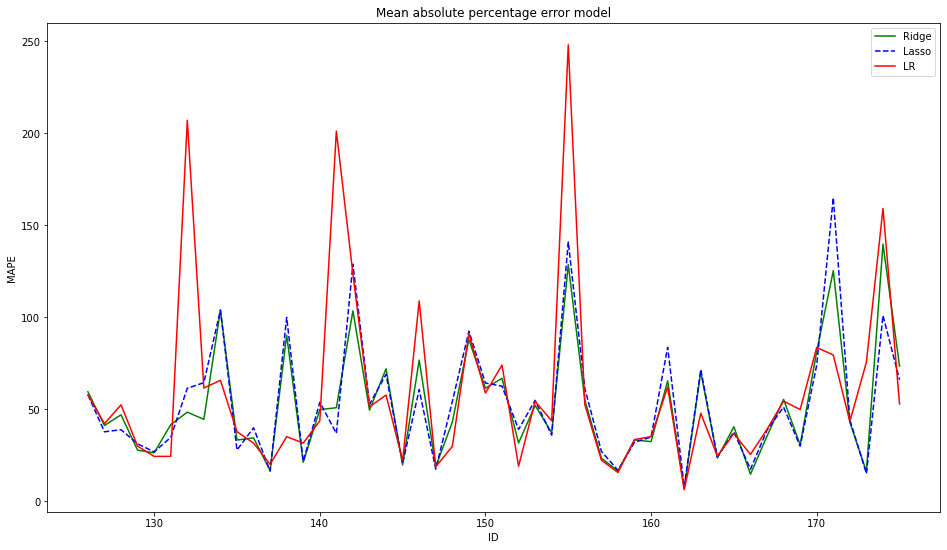

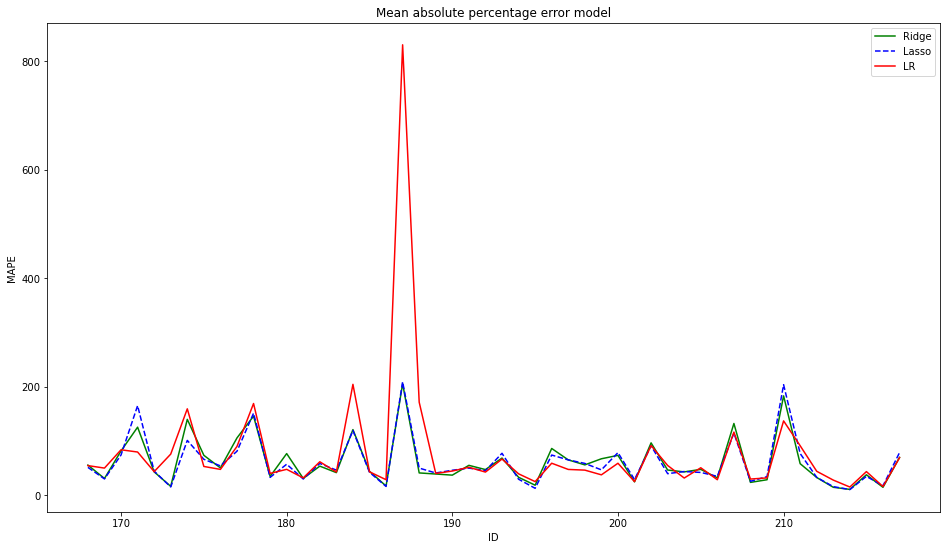

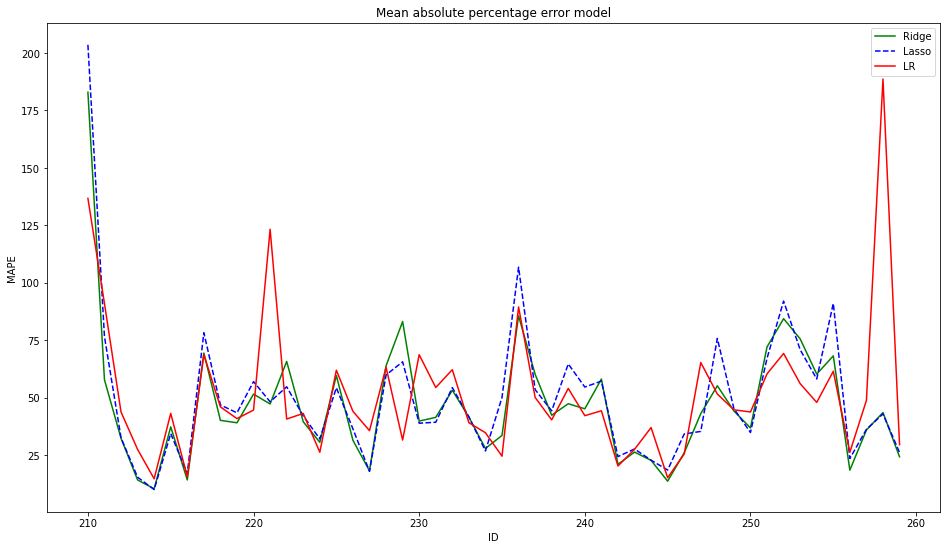

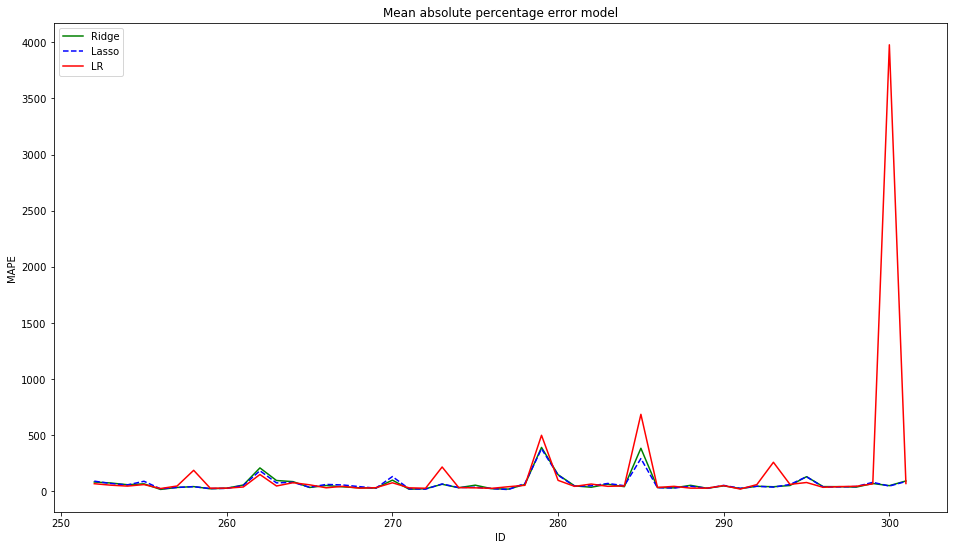

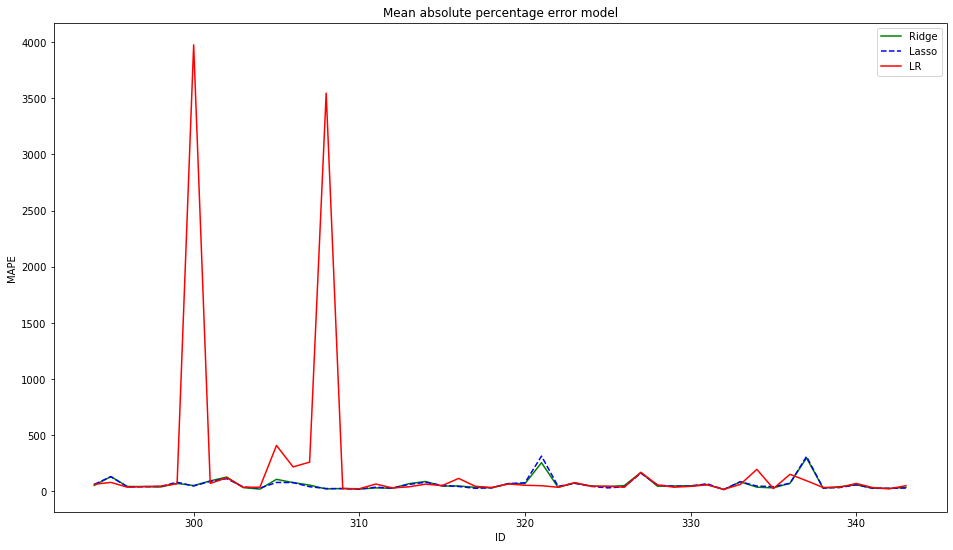

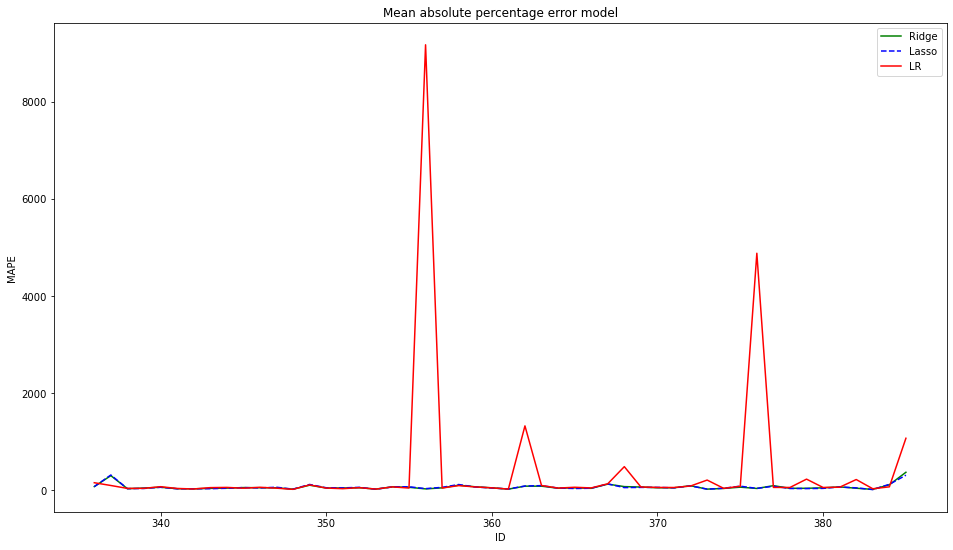

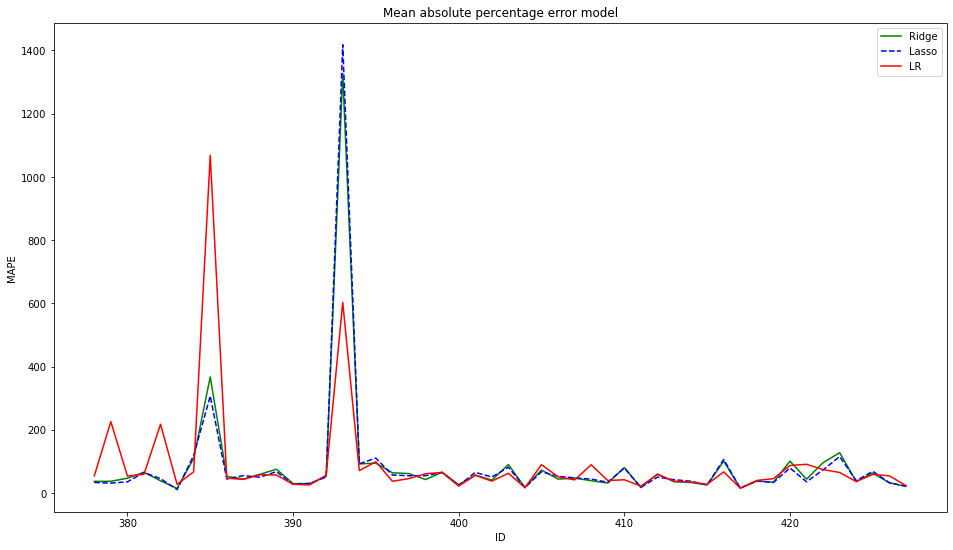

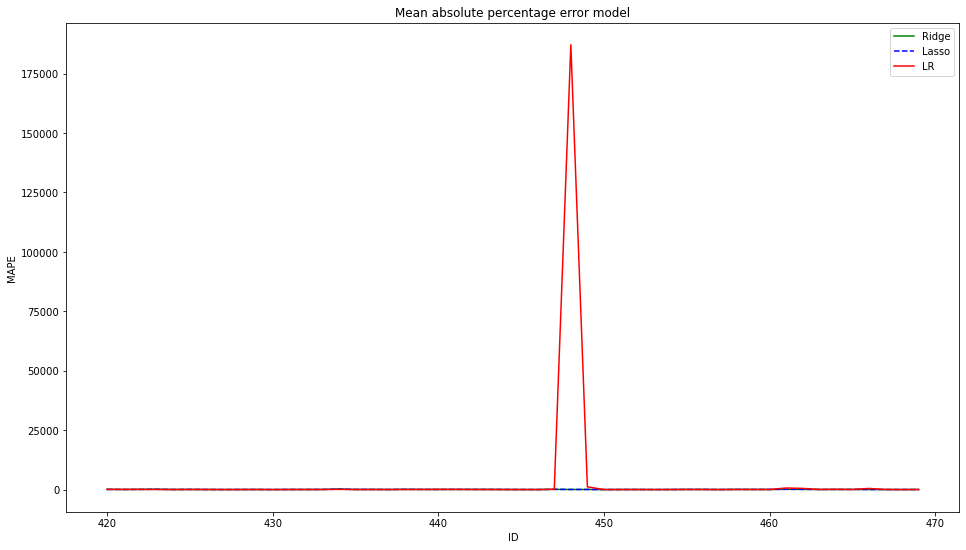

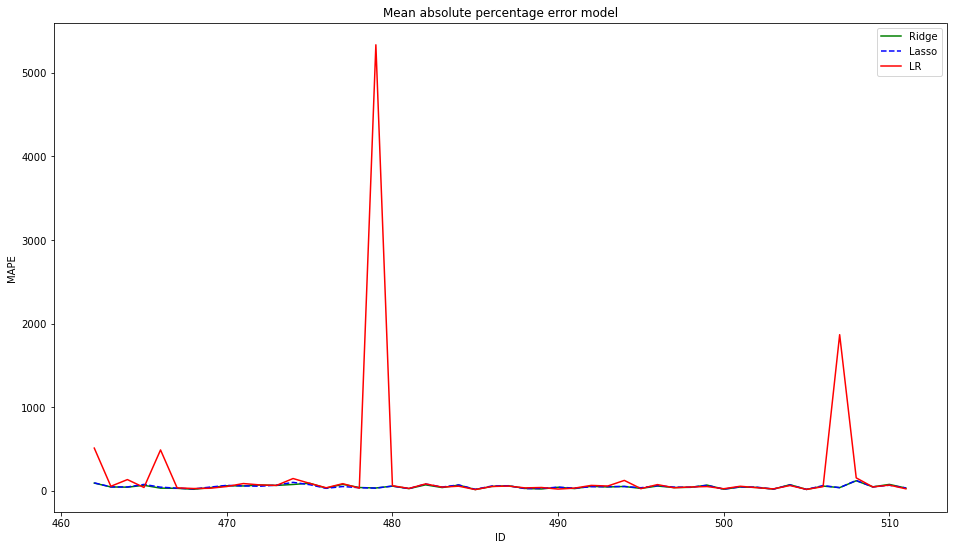

In [36]:
for i in range(0, len(mape_line_ridge)-43, 42):
    plt.figure(figsize=(16, 9))
    plt.plot(mape_line_ridge[i:i+50].index, mape_line_ridge['MAPE'][i:i+50].values, '-g', label='Ridge')
    plt.plot(mape_line_lasso[i:i+50].index, mape_line_lasso['MAPE'][i:i+50].values, '--b', label='Lasso')
    plt.plot(mape_line_lr[i:i+50].index, mape_line_lr['MAPE'][i:i+50].values, 'r', label='LR')
    plt.xlabel('ID')
    plt.ylabel('MAPE')
    plt.title('Mean absolute percentage error model')
    plt.legend()
    plt.show()

In [37]:
print("MAPE with Ridge:", mape_line_ridge['MAPE'].mean())
print("MAPE with Lasso:", mape_line_lasso['MAPE'].mean())
print("MAPE with LR:", mape_line_lr['MAPE'].mean())

MAPE with Ridge: 59.00258357789143
MAPE with Lasso: 59.205260256150105
MAPE with LR: 508.211084137128
